**Extract Data**

In [1]:
import zipfile
import os


zip_path = "/content/data.zip"
extract_path = "/content/data"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


**Import Required Libraries**

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt


**Load CSV Files**

In [3]:
train_csv_path = "/content/train.csv"
test_csv_path = "/content/test.csv"

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)


print("Train Data Sample:\n", df_train.head())
print("Test Data Sample:\n", df_test.head())


Train Data Sample:
            image_path  label              latex  user_id  example_id
0  data/v2-118246.png    786  \circlearrowright    16925      118246
1   data/v2-66308.png    194            \propto    16925       66308
2  data/v2-142335.png    951             \nabla    16925      142335
3  data/v2-134240.png    921                 \|    16925      134240
4   data/v2-82460.png    531                \mp    16925       82460
Test Data Sample:
            image_path  user_id  example_id
0  data/v2-114921.png    16925      114921
1  data/v2-121504.png    16925      121504
2   data/v2-74325.png    16925       74325
3   data/v2-30262.png     6662       30262
4  data/v2-109694.png    16925      109694


**Define Image Transformations**

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


**Define Custom Dataset Class**

In [5]:
class SymbolDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, test=False):
        self.df = df
        self.root_dir = root_dir.rstrip("/")
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_filename = os.path.basename(self.df.iloc[idx, 0])
        img_path = os.path.join(self.root_dir, img_filename)

        if not os.path.exists(img_path):
            print(f"Warning: File {img_path} not found!")
            return None, None

        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        if self.test:
            return image
        else:
            label = int(self.df.iloc[idx, 1])
            return image, torch.tensor(label, dtype=torch.long)


**Create DataLoader**

In [6]:

ROOT_DIR = "/content/data/data"

train_dataset = SymbolDataset(df_train, root_dir=ROOT_DIR, transform=transform)
test_dataset = SymbolDataset(df_test, root_dir=ROOT_DIR, transform=transform, test=True)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 134586
Test samples: 33647


**Define CNN Model**

In [7]:
class SymbolClassifier(nn.Module):
    def __init__(self, num_classes=369):
        super(SymbolClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


**Check Label Range in df_train**

In [9]:
print("Min Label:", df_train["label"].min())
print("Max Label:", df_train["label"].max())
print("Unique Labels:", df_train["label"].nunique())


Min Label: 31
Max Label: 1400
Unique Labels: 369


**Remap Labels to Ensure Proper Range**

In [10]:

unique_labels = sorted(df_train["label"].unique())
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}


df_train["label"] = df_train["label"].map(label_mapping)


**Verify Labels After Fixing**

In [11]:
print("Fixed Min Label:", df_train["label"].min())
print("Fixed Max Label:", df_train["label"].max())
print("Total Unique Labels:", df_train["label"].nunique())


Fixed Min Label: 0
Fixed Max Label: 368
Total Unique Labels: 369


**Ensure Labels Are Integers**

In [12]:
df_train["label"] = df_train["label"].astype(int)
df_train = df_train.dropna(subset=["label"])


**Train the Model on CPU**

In [13]:
device = torch.device("cpu")

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")


model = SymbolClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, epochs=10)


Epoch 1/10 | Loss: 1.3070 | Accuracy: 67.68%
Epoch 2/10 | Loss: 0.7427 | Accuracy: 78.25%
Epoch 3/10 | Loss: 0.6154 | Accuracy: 80.79%
Epoch 4/10 | Loss: 0.5227 | Accuracy: 83.04%
Epoch 5/10 | Loss: 0.4547 | Accuracy: 84.62%
Epoch 6/10 | Loss: 0.3970 | Accuracy: 86.19%
Epoch 7/10 | Loss: 0.3479 | Accuracy: 87.58%
Epoch 8/10 | Loss: 0.3064 | Accuracy: 88.83%
Epoch 9/10 | Loss: 0.2725 | Accuracy: 89.95%
Epoch 10/10 | Loss: 0.2433 | Accuracy: 91.06%


**Evaluate Model Accuracy**

In [14]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc

evaluate_model(model, train_loader)


Accuracy: 95.93%


95.93419820783737

**Final Training**

In [16]:
train_acc = evaluate_model(model, train_loader)
print(f"Training Accuracy: {train_acc:.2f}%")


Accuracy: 95.93%
Training Accuracy: 95.93%


**Model Testing on Sample Image**

In [17]:
sample_img, _ = train_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    pred = model(sample_img)
    predicted_label = pred.argmax(dim=1).item()
print(f"Predicted Label: {predicted_label}")


Predicted Label: 236


**Saving the Model**

In [18]:
torch.save(model.state_dict(), "symbol_classifier.pth")
print("Model saved successfully!")


Model saved successfully!


**Print the Image for a Predicted Label**

Predicted Label: 236


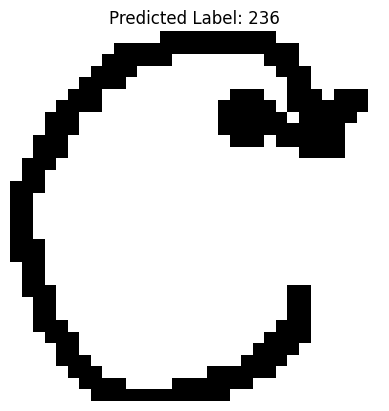

In [19]:
import matplotlib.pyplot as plt
import numpy as np


sample_img, sample_label = train_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(sample_img)
    predicted_label = pred.argmax(dim=1).item()

print(f"Predicted Label: {predicted_label}")

for img, label in train_dataset:
    if label == predicted_label:
        image_to_show = img.squeeze().cpu().numpy()
        break


plt.imshow(image_to_show, cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.axis("off")
plt.show()


**Display an Image of a Specific Label-100**

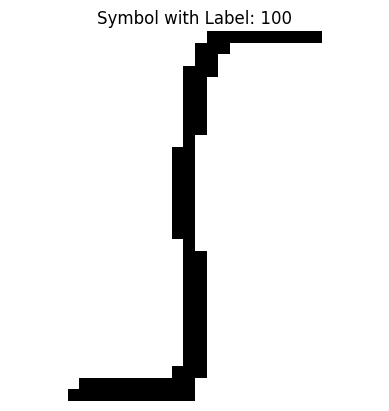

In [20]:
import matplotlib.pyplot as plt
import numpy as np


target_label = 100

image_to_show = None
for img, label in train_dataset:
    if label == target_label:
        image_to_show = img.squeeze().cpu().numpy()
        break


if image_to_show is not None:
    plt.imshow(image_to_show, cmap="gray")
    plt.title(f"Symbol with Label: {target_label}")
    plt.axis("off")
    plt.show()
else:
    print(f"No image found for label {target_label}.")


**Display an Image of a Specific Label-1**

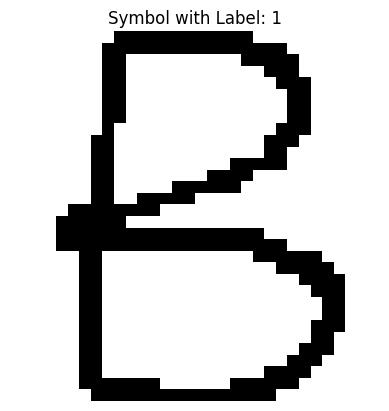

In [21]:
import matplotlib.pyplot as plt
import numpy as np


target_label = 1

image_to_show = None
for img, label in train_dataset:
    if label == target_label:
        image_to_show = img.squeeze().cpu().numpy()
        break


if image_to_show is not None:
    plt.imshow(image_to_show, cmap="gray")
    plt.title(f"Symbol with Label: {target_label}")
    plt.axis("off")
    plt.show()
else:
    print(f"No image found for label {target_label}.")


**Generate Submission File**

In [23]:
import os


TEST_DIR = "/content/data/data"


test_filenames = sorted(os.listdir(TEST_DIR))

print("Total test images:", len(test_filenames))


Total test images: 168233


**Generate Predictions for Test Data**

In [24]:
import torch
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


def predict_image(image_path, model):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    model.eval()

    with torch.no_grad():
        output = model(image)
        predicted_label = torch.argmax(output, dim=1).item()

    return predicted_label

predictions = [predict_image(os.path.join(TEST_DIR, fname), model) for fname in test_filenames]

print("Predictions completed!")


Predictions completed!


**Create & Save submission.csv**

In [25]:
import pandas as pd

submission_df = pd.DataFrame({
    "image_id": test_filenames,
    "label": predictions
})

submission_df.to_csv("submission.csv", index=False)
print("submission.csv generated successfully!")


submission.csv generated successfully!


**Verify submission.csv Format**

In [26]:
import pandas as pd

submission = pd.read_csv("submission.csv")
print(submission.head())









       image_id  label
0  v2-00000.png    193
1  v2-00001.png    193
2  v2-00002.png    266
3  v2-00003.png    193
4  v2-00004.png    193


**Submission.csv file is verified**